In [1]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
import sys
sys.path.append('/home/fdfuller/work/dgp_iwvi_gpflow2/')
import gpflow
import numpy as np
import tensorflow as tf
from typing import Tuple, Optional, List, Union
import dgp_iwvi_gpflow2.layers as layers
from dgp_iwvi_gpflow2.reference_spectra import *
from dgp_iwvi_gpflow2.exact_models import GPMM1D_Exact, GPMM2D_Exact, cartesian_prod
import attr
import tensorflow_probability as tfp
from matplotlib.pyplot import *
from gpflow.utilities import print_summary
import matplotlib.colors as colors
import h5py
from sklearn.neighbors import KernelDensity
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [3]:
def kernelize_samples(S, bw=0.001, npts = 1000):
    l,h = np.percentile(S[:],[1,99])
    ax = np.linspace(l, h, npts)[:,None]
    scores = np.zeros((S.shape[0],npts), S.dtype)
    for k,s in enumerate(S):
        kde = KernelDensity(bandwidth=bw)
        kde.fit(s.reshape(-1,1))
        scores[k,:] = kde.score_samples(ax)
    return scores, ax

def first_moment(axis, specs):
    return (axis[None,:]*specs/(specs.sum(-1)[:,None])).sum(-1)

def second_central_moment(axis, specs):
    uncentered_moment = ((axis**2)[None,:]*specs/(specs.sum(-1)[:,None])).sum(-1)
    return uncentered_moment - first_moment(axis, specs)**2

def sumnorm(x):
    return x/x.sum()

def centered_gaussian_window(L, width_in_pixels=10, power=1):
    x = np.arange(L).astype('float64')
    x -= x.max()/2
    sigma = width_in_pixels/2.355
    f = np.exp(-(x)**(2*power)/(2*sigma**(2*power)))
    return f

def fftfilter(x, w=8, power=1):
    z = np.fft.fftshift(np.fft.fft(x))
    f = centered_gaussian_window(len(z), width_in_pixels=w, power=power)
    fz = f*z
    return np.abs(np.fft.ifft(np.fft.fftshift(fz)))

def windowed_freq_content(X, axis, emin, emax):
    imin = np.argmin((axis - emin)**2)
    imax = np.argmin((axis - emax)**2)
    return X[:,imax:imin].sum(-1)

def lsq_mse(yhat, y):
    """fits yhat to y through scaling and offset only"""
    yhat_aug = np.concatenate([yhat.reshape(-1)[:,None], np.ones_like(yhat.reshape(-1))[:,None]],-1)
    m, b = np.linalg.lstsq(yhat_aug, y.reshape(-1)[:,None], rcond=None)[0]
    return ((yhat*m + b - y)**2).sum()
    

In [4]:
dname = 'clean_sorted_200mM_ferrocyanide_pink_all'
# dname = 'finely_corrected_and_biased_pink'
with h5py.File('/home/fdfuller/work/data/sacla2017/' + dname + '.h5','r') as fid:
    inp_axis = np.array(fid['inp_axis'])
    out_axis = np.array(fid['out_axis_binned'])
    Xpinka = np.array(fid['X_by_first_sase_moment_cluster_a']).astype('float64')
    Xpinkb = np.array(fid['X_by_first_sase_moment_cluster_b']).astype('float64')
    Xpink = np.concatenate([Xpinka, Xpinkb],0)
    xmax = Xpink.max()
    Xpink /= xmax
    Xpinka /= xmax
    Xpinkb /= xmax
    Ypinka = np.array(fid['Ybinned_by_first_sase_moment_cluster_a']).astype('float64')
    Ypinkb = np.array(fid['Ybinned_by_first_sase_moment_cluster_b']).astype('float64')
    Ypink = np.concatenate([Ypinka, Ypinkb],0)
    ymax = Ypink.max()
    Ypink /= ymax
    Ypinka /= ymax
    Ypinkb /= ymax

## Reportable Information on axes

In [9]:
print('incidence axis sampling rate in eV', np.abs(np.diff(inp_axis).mean())*1E3)
print('emission axis sampling rate in eV', np.abs(np.diff(out_axis).mean())*1E3) 

incidence axis sampling rate in eV 0.6101154103389556
emission axis sampling rate in eV 0.6190476190476101


## There is some etaloning in the SASE spectrometer, we can remove it

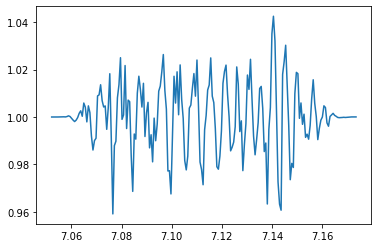

In [5]:
multiplicative_filter = np.abs(((fftfilter(
    sumnorm(Xpink.mean(0)), 35, power=2
)/sumnorm(Xpink.mean(0)) - 1) * centered_gaussian_window(200, 160, 4)) + 1)
figure()
plot(inp_axis, multiplicative_filter)

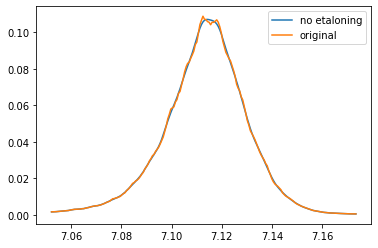

In [6]:
figure()
plot(inp_axis, (Xpink * multiplicative_filter[None,:]).mean(0), label='no etaloning')
plot(inp_axis, (Xpink).mean(0), label='original')
legend()

## Select data for 101k shot dataset

In [7]:
multiplicative_filter = np.abs(((fftfilter(
    sumnorm(Xpink.mean(0)), 35, power=2
)/sumnorm(Xpink.mean(0)) - 1) * centered_gaussian_window(200, 160, 4)) + 1)
X = Xpink[:,:] * multiplicative_filter[None,:]
qpink_roi_min = 5
qpink_roi_max = 23
shot_choices = np.load('101k_shot_selection.npy',allow_pickle=True)[()]
maska = shot_choices['shot_choicesa']
maskb = shot_choices['shot_choicesb']
mask = np.concatenate([maska,maskb])
Y = Ypink[:,qpink_roi_min:qpink_roi_max]
# mask = np.concatenate([maska,maskb],0)
Xsel = X[mask,:]
# remove elastic scatter from SASE spectrum
adj = Xsel.sum(-1)[:,None]*(0.0003)
Xsel -= adj
data2 = (Xsel, Y[mask,:])
rixs_model = GPMM2D_Exact(data2, gpflow.kernels.Matern52(lengthscales=0.1, variance=0.01),
                     gpflow.kernels.RBF(lengthscales=0.1, variance=1.0),
   noise_variance=0.01, mean_function=gpflow.mean_functions.Zero(), jitter=1e-8)
#trigger compilation of loss
loss_fn = rixs_model.training_loss
loss_fn()
opt = gpflow.optimizers.Scipy()
report = opt.minimize(loss_fn, rixs_model.trainable_variables, options=dict(maxiter=100))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not call `graph_parents`.


In [8]:
Npred = 500
normalized_raxis = np.linspace(-1,1,Npred)[:,None]
normalized_qaxis = np.linspace(-1,1,Npred//10)[:,None]
normalized_qaxis = np.linspace(-1,1,18)[:,None]
pred_raxis = np.linspace(inp_axis.max(), inp_axis.min(), Npred)
pred_qaxis = np.linspace(out_axis[qpink_roi_min:qpink_roi_max].max(),
                         out_axis[qpink_roi_min:qpink_roi_max].min(), 18)
mpink, vpink = rixs_model.predict_f(raxis=normalized_raxis, qaxis=normalized_qaxis)
mpink = tf.squeeze(mpink).numpy()
spink  = tf.math.sqrt(vpink).numpy()

In [9]:
def plot_rixs(pred_raxis, pred_qaxis, data, std_devs, name, rmin=210, rmax=280, dmin=None, dmax=None, save=False):
    if dmin is None:
        dmin = rmin
    if dmax is None:
        dmax = rmax
    fig = figure()
    ax = fig.add_subplot(111)
    rmin = 210
    rmax = 280
    vmin=data[:,dmin:dmax].min()
    vmax=data[:,dmin:dmax].max()
    
    
    colors_neg = cm.Spectral(np.linspace(0, 0.5, 256))
    colors_pos = cm.YlGnBu(np.linspace(0.0, 1, 256)**0.75)
    all_colors = np.vstack((colors_neg, colors_pos))
    cmap = colors.LinearSegmentedColormap.from_list('cmap',
        all_colors)
    if vmin > 0:
        norm = colors.Normalize(vmin = vmin, vmax = vmax)
    else:
        norm = colors.DivergingNorm(vmin=vmin, vcenter = 0, vmax = vmax) 
    im = ax.contourf(pred_raxis[rmin:rmax], pred_qaxis, data[:,dmin:dmax], 100,
                     cmap=cmap,
                     norm=norm
                    )
    ax.contour(pred_raxis[rmin:rmax], pred_qaxis, data[:,dmin:dmax]/std_devs[:,dmin:dmax],
               (np.arange(30)-10)[::2], colors='black', linewidths=0.5)
    ax.set_aspect(0.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cax.set_aspect(6.3)
    ticks = [0.] + np.round(np.linspace(0,data[:,dmin:dmax].max(),5),3).tolist()[:-1]
    colorbar(im, cax=cax, ticks=[ticks])
    if save:
        savefig(f'./figures_final/{name}.pdf')

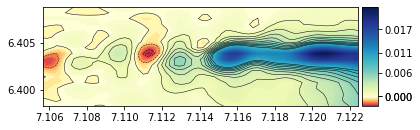

In [10]:
plot_rixs(pred_raxis, pred_qaxis, mpink, spink, 'ka1_rixs_101kshots_std_dev_scale_black', save=True)

In [11]:
with h5py.File('/home/fdfuller/work/data/sacla2017/clean_sorted_200mM_ferrocyanide_mono.h5','r') as fid:
    Xmono = np.array(fid['X'])
    Ymono = np.array(fid['Y'])
    inp_axis = np.array(fid['inp_axis'])
Xmono /= Xmono.max()
Ymono /= Ymono.max()

In [12]:
Xm = Xmono[:,:] * multiplicative_filter
Xm -= 0.00025*Xm.sum(-1)[:,None]
o_range_ka1 = slice(5,23)
Ym = Ymono[:,o_range_ka1]
data_mono = (Xm[:,:], Ym[:,:])
mono_model = GPMM2D_Exact(data_mono, gpflow.kernels.RBF(lengthscales=0.1, variance=0.01),
                     gpflow.kernels.RBF(lengthscales=0.1, variance=1.0),
   noise_variance=0.01, mean_function=gpflow.mean_functions.Zero(), jitter=1e-8)
loss_fn = mono_model.training_loss
loss_fn()
opt = gpflow.optimizers.Scipy()
report = opt.minimize(loss_fn, mono_model.trainable_variables, options=dict(maxiter=100))

In [13]:
Npred = 500
normalized_raxis = np.linspace(-1,1,Npred)[:,None]
# normalized_qaxis = np.linspace(-1,1,Npred//10)[:,None]
normalized_qaxis = np.linspace(-1,1,18)[:,None]
pred_raxis = np.linspace(inp_axis.max(), inp_axis.min(), Npred)
# pred_qaxis = np.linspace(out_axis[o_range_ka1].max(), out_axis[o_range_ka1].min(), Npred//10)
pred_qaxis = np.linspace(out_axis[o_range_ka1].max(), out_axis[o_range_ka1].min(), 18)
m, v = mono_model.predict_f(raxis=normalized_raxis, qaxis=normalized_qaxis)
m = tf.squeeze(m).numpy()
s  = tf.math.sqrt(v).numpy()

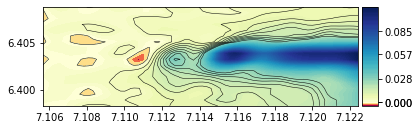

In [14]:
plot_rixs(pred_raxis, pred_qaxis, m, s, 'ka1_mono_rixs_42kshots_std_dev_scale_black')

## Compare HERFD slices of mono and pink solution

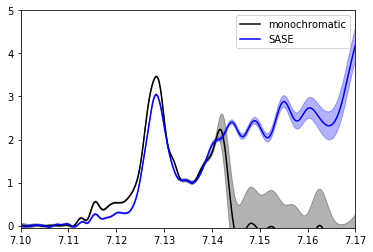

In [15]:
fig = figure()
ax = fig.add_subplot(111)
i = np.argmin((pred_qaxis - 6.4031)**2)
# j = np.argmin((pred_qaxis - 6.401)**2)
mu = m[i,:]
sig = s[i,:]
norm_pixel = np.argmin((pred_raxis - 7.136)**2)
mono_norm = mu[norm_pixel]
ax.plot(pred_raxis, m[i,:]/mono_norm, 'k', label='monochromatic')
ax.fill_between(pred_raxis, (m[i,:] + 2*s[i,:])/mono_norm, (m[i,:] - 2*s[i,:])/mono_norm,
                color='k', alpha=0.3)
pink_norm = mpink[i,norm_pixel]
ax.fill_between(pred_raxis, (mpink[i,:] + 2*spink[i,:])/pink_norm, 
                (mpink[i,:] - 2*spink[i,:])/pink_norm, color='b', alpha=0.3)
ax.plot(pred_raxis, mpink[i,:]/pink_norm, 'b', label='SASE')

# ax.plot(inp_axis, 0.6*Xm.mean(0)/(Xm.mean(0).max(0)), 'r--', label='SASE envelope')
xlim([7.100, 7.170])
ylim([-0.05, 5.0])
legend(loc=1)

## compute correction for profile so that mono and pink match in contrast

In [16]:
def gaussian_filter(axis, center=7.137, fwhm=0.022, offset=0.4, gain=0.6):
    return offset+gain*np.exp(-(axis-center)**2/(2*(fwhm/2.355)**2))

(0.1, 1.2)

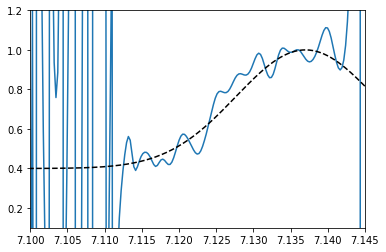

In [17]:
figure()
plot(pred_raxis, (mpink[i,:]/pink_norm)/(m[i,:]/mono_norm))
plot(pred_raxis, gaussian_filter(pred_raxis),'k--')
xlim([7.100, 7.145])
ylim([0.1, 1.2])

## Preview the correction

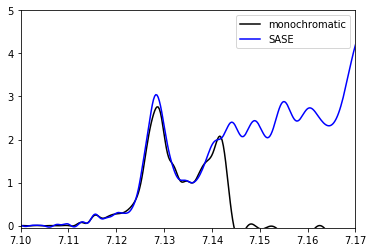

In [18]:
fig = figure()
ax = fig.add_subplot(111)
i = np.argmin((pred_qaxis - 6.4031)**2)
# j = np.argmin((pred_qaxis - 6.401)**2)
mu = m[i,:]
sig = s[i,:]
norm_pixel = np.argmin((pred_raxis - 7.136)**2)
mono_norm = mu[norm_pixel]
ax.plot(pred_raxis, gaussian_filter(pred_raxis)*m[i,:]/mono_norm, 'k', label='monochromatic')
pink_norm = mpink[i,norm_pixel]
ax.plot(pred_raxis, mpink[i,:]/pink_norm, 'b', label='SASE')

# ax.plot(inp_axis, 0.6*Xm.mean(0)/(Xm.mean(0).max(0)), 'r--', label='SASE envelope')
xlim([7.100, 7.170])
ylim([-0.05, 5.0])
legend(loc=1)

## Apply it to SASE and recompute corrected mono fit

In [19]:
Xm_corr = Xmono[:,:] * multiplicative_filter / gaussian_filter(inp_axis)
Xm_corr -= 0.00025*Xm_corr.sum(-1)[:,None]
o_range_ka1 = slice(5,23)
Ym = Ymono[:,o_range_ka1]
data_mono = (Xm_corr[:,:], Ym[:,:])
mono_model_corr = GPMM2D_Exact(data_mono, gpflow.kernels.RBF(lengthscales=0.1, variance=0.01),
                     gpflow.kernels.RBF(lengthscales=0.1, variance=1.0),
   noise_variance=0.01, mean_function=gpflow.mean_functions.Zero(), jitter=1e-8)
loss_fn = mono_model_corr.training_loss
loss_fn()
opt = gpflow.optimizers.Scipy()
report = opt.minimize(loss_fn, mono_model_corr.trainable_variables, options=dict(maxiter=100))

In [20]:
Npred = 500
mcorr, vcorr = mono_model_corr.predict_f(raxis=normalized_raxis, qaxis=normalized_qaxis)
mcorr = tf.squeeze(mcorr).numpy()
scorr  = tf.math.sqrt(vcorr).numpy()

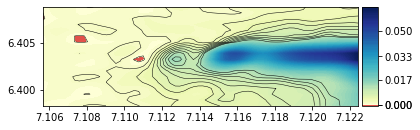

In [21]:
plot_rixs(pred_raxis, pred_qaxis, mcorr, scorr, 'ka1_mono_rixs_corrected_42kshots_std_dev_scale_black', save=True)

## Comparison of pink to corrected mono

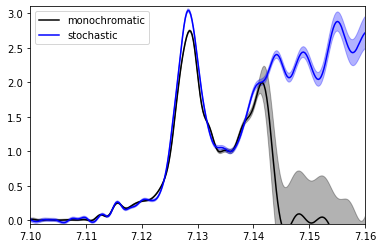

In [22]:
fig = figure()
ax = fig.add_subplot(111)
i = np.argmin((pred_qaxis - 6.4031)**2)
# j = np.argmin((pred_qaxis - 6.401)**2)
mu = mcorr[i,:]
sig = scorr[i,:]
norm_pixel = np.argmin((pred_raxis - 7.136)**2)
mono_norm = mu[norm_pixel]
ax.plot(pred_raxis, mu/mono_norm, 'k', label='monochromatic')
ax.fill_between(pred_raxis, (mu + 2*sig)/mono_norm, (mu - 2*sig)/mono_norm,
                color='k', alpha=0.3)
pink_norm = mpink[i,norm_pixel]
ax.fill_between(pred_raxis, (mpink[i,:] + 2*spink[i,:])/pink_norm, 
                (mpink[i,:] - 2*spink[i,:])/pink_norm, color='b', alpha=0.3)
ax.plot(pred_raxis, mpink[i,:]/pink_norm, 'b', label='stochastic')

# ax.plot(inp_axis, 0.6*Xm.mean(0)/(Xm.mean(0).max(0)), 'r--', label='SASE envelope')
xlim([7.100, 7.160])
ylim([-0.05, 3.1])
legend(loc=0)
savefig('./figures_final/101k_shot_herfd_overlay_at_6.4031keV.pdf')

## Compare corrected vs uncorrected for SI

<IPython.core.display.Javascript object>


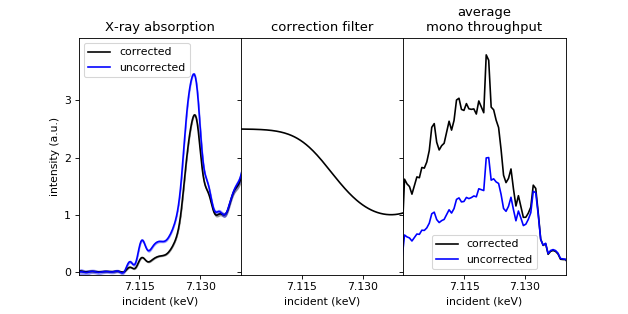

In [176]:
fig, (ax, ax2, ax3) = subplots(1,3,sharey='row',figsize=(8,4))
fig.subplots_adjust(wspace=0)
i = np.argmin((pred_qaxis - 6.4033)**2)
# j = np.argmin((pred_qaxis - 6.401)**2)
mu = mcorr[i,:]
sig = scorr[i,:]
norm_pixel = np.argmin((pred_raxis - 7.136)**2)
mono_norm = mu[norm_pixel]
ax.plot(pred_raxis, mu/mono_norm, 'k', label='corrected')
ax.fill_between(pred_raxis, (mu + 2*sig)/mono_norm, (mu - 2*sig)/mono_norm,
                color='k', alpha=0.3)
mu = m[i,:]
mono_norm = mu[norm_pixel]
sig = s[i,:]
ax.plot(pred_raxis, mu/mono_norm, 'b', label='uncorrected')
ax.fill_between(pred_raxis, (mu + 2*sig)/mono_norm, (mu - 2*sig)/mono_norm,
                color='b', alpha=0.3)
ax.title.set_text('X-ray absorption')
ax.set_xlim([7.100, 7.14])
ax.set_xticks([7.115, 7.13])
ax.set_yticks([0., 1.0, 2.0, 3.0])
ax.set_ylim([-0.05, 4.1])
ax.set_ylabel('intensity (a.u.)')
ax.set_xlabel('incident (keV)')
ax.legend()

ax2.plot(pred_raxis, 1/gaussian_filter(pred_raxis), color='k')
ax2.title.set_text('correction filter')
ax2.set_xlim([7.100, 7.14])
ax2.set_xticks([7.115, 7.13])
# ax2.set_ylim([-0.05, 3.5])
ax2.set_xlabel('incident (keV)')

ax3.plot(inp_axis, 2*Xm_corr.mean(0)/Xm.mean(0).max(), color='k', label='corrected')
ax3.plot(inp_axis, 2*Xm.mean(0)/Xm.mean(0).max(), color='b', label='uncorrected')
ax3.title.set_text('average\nmono throughput')
ax3.set_xlim([7.100, 7.14])
ax3.set_xticks([7.115, 7.13])
# ax3.set_ylim([-0.05, 3.5])
ax3.set_xlabel('incident (keV)')
ax3.legend()

savefig('./figures_final/SI_mono_correction_at_6.4033keV.pdf')


# legend(loc=0)

## Now to compare to a sub-selection of pink to match the number of mono shots

In [24]:
shot_choices_limited = np.load('fig2_selected_shots.npy',allow_pickle=True)[()]
maska_lim = shot_choices_limited['shot_choicesa']
maskb_lim = shot_choices_limited['shot_choicesb']
mask_lim = np.concatenate([maska_lim,maskb_lim])
Xpink_lim = Xpink[mask_lim,:]
adj = Xpink_lim.sum(-1)[:,None]*(0.00035)
Xpink_lim -= adj
Ypink_lim = Ypink[mask_lim,qpink_roi_min:qpink_roi_max]
data_pink_lim = (Xpink_lim, Ypink_lim)
print(Xpink_lim.shape)

(42000, 200)


In [25]:
model_star = GPMM2D_Exact(data_pink_lim, 
                    gpflow.kernels.Matern52(lengthscales=0.1, variance=0.01),
                    gpflow.kernels.RBF(lengthscales=0.1, variance=1.0),
                   noise_variance=rixs_model.likelihood.variance.value().numpy(),
                    mean_function=None, jitter=1e-9)
loss_fn = model_star.training_loss
loss_fn()
opt = gpflow.optimizers.Scipy()
report = opt.minimize(loss_fn, model_star.trainable_variables, options=dict(maxiter=300))

mstar, vstar = model_star.predict_f(raxis=normalized_raxis, qaxis=normalized_qaxis)
mstar = tf.squeeze(mstar).numpy()
sstar  = tf.math.sqrt(vstar).numpy()

In [26]:
model_star

name,class,transform,prior,trainable,shape,dtype,value
GPMM2D_Exact.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.000405157
GPMM2D_Exact.reduced_kernel.variance,Parameter,Softplus,,True,(),float64,0.00179201
GPMM2D_Exact.reduced_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0830694
GPMM2D_Exact.observed_kernel.variance,Parameter,Softplus,,True,(),float64,0.441577
GPMM2D_Exact.observed_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.194413
GPMM2D_Exact._pred_jitter_kernel.variance,Parameter,Softplus,,False,(),float64,1e-09


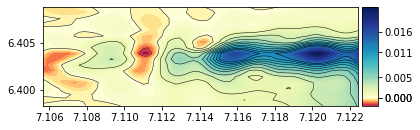

In [27]:
plot_rixs(pred_raxis, pred_qaxis, mstar, sstar, 'ka1_rixs_42kshots_std_dev_scale_black', save=True)

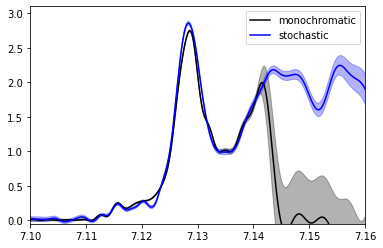

In [28]:
fig = figure()
ax = fig.add_subplot(111)
i = np.argmin((pred_qaxis - 6.4031)**2)
# j = np.argmin((pred_qaxis - 6.401)**2)
mu = mcorr[i,:]
sig = scorr[i,:]
norm_pixel = np.argmin((pred_raxis - 7.136)**2)
mono_norm = mu[norm_pixel]
ax.plot(pred_raxis, mu/mono_norm, 'k', label='monochromatic')
ax.fill_between(pred_raxis, (mu + 2*sig)/mono_norm, (mu - 2*sig)/mono_norm,
                color='k', alpha=0.3)
pink_norm = mstar[i,norm_pixel]
ax.fill_between(pred_raxis, (mstar[i,:] + 2*sstar[i,:])/pink_norm, 
                (mstar[i,:] - 2*sstar[i,:])/pink_norm, color='b', alpha=0.3)
ax.plot(pred_raxis, mstar[i,:]/pink_norm, 'b', label='stochastic')

# ax.plot(inp_axis, 0.6*Xm.mean(0)/(Xm.mean(0).max(0)), 'r--', label='SASE envelope')
xlim([7.100, 7.160])
ylim([-0.05, 3.1])
legend(loc=0)
savefig('./figures_final/42k_shot_herfd_overlay_at_6.4031keV.pdf')

In [168]:
def plot_rixs_composite(pred_raxis, pred_qaxis, 
                        mu_pink, std_devs_pink, 
                        mu_mono, std_devs_mono,
                        rmin=210, rmax=280, 
                        dmin=None, dmax=None,
                        herfd_energy = 6.4033,
                        save=False, name=None):
    if dmin is None:
        dmin = rmin
    if dmax is None:
        dmax = rmax
    fig = figure(figsize=(16,4))

    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax3 = fig.add_subplot(gs[:, 1])
    gs.update(wspace = 0.01, hspace=0.03)
    
    ## RIXS plotting
    def rixs_plot(ax, mus, std_devs):
        colors_neg = cm.Spectral(np.linspace(0, 0.5, 256))
        colors_pos = cm.YlGnBu(np.linspace(0.0, 1, 256)**0.75)
        all_colors = np.vstack((colors_neg, colors_pos))
        cmap = colors.LinearSegmentedColormap.from_list('cmap',
            all_colors)
        vmin=mus[:,dmin:dmax].min()
        vmax=mus[:,dmin:dmax].max()
        if vmin > 0:
            norm = colors.Normalize(vmin = vmin, vmax = vmax)
        else:
            norm = colors.DivergingNorm(vmin=vmin, vcenter = 0, vmax = vmax) 
        im = ax.contourf(pred_raxis[rmin:rmax], pred_qaxis, mus[:,dmin:dmax], 100,
                         cmap=cmap,
                         norm=norm
                        )
        ax.contour(pred_raxis[rmin:rmax], pred_qaxis, mus[:,dmin:dmax]/std_devs[:,dmin:dmax],
                   (np.arange(27)-10)[::2], colors='black', linewidths=0.5)
#         ax.set_aspect(0.5)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
#         cax.set_aspect(6.3)
        ticks = np.unique(np.array([0.] + np.round(np.linspace(0,mus[:,dmin:dmax].max(),5),3).tolist()[:-1])).tolist()
        colorbar(im, cax=cax, ticks=[ticks])
        return ax
    
    rixs_plot(ax1, mu_pink, std_devs_pink)
    rixs_plot(ax2, mu_mono, std_devs_mono)
    
    ax1.set_xticks([])
    ax2.set_xticks([7.1129, 7.1159, 7.1202])
    ax1.set_yticks([6.4, 6.4033, 6.407])
    ax2.set_yticks([6.4, 6.4033, 6.407])
    ax2.set_xlabel('incident (keV)')
    ax2.set_ylabel('monochromatic\nemission (keV)')
    ax1.set_ylabel('stochastic\nemission (keV)')
    ax1.grid(linewidth=1., color='k', linestyle='--')
    ax2.grid(linewidth=1., color='k', linestyle='--')
    
    def herfd_plot(ax, mus, std_devs, herfd_pixel, norm_pixel, label, color='k'):
        norm = mus[herfd_pixel, norm_pixel]
        mu = mus[herfd_pixel,:]/norm
        sig = std_devs[herfd_pixel,:]/norm
        ax.plot(pred_raxis, mu, color=color, label=label)
        ax.fill_between(pred_raxis, (mu + 2*sig), (mu - 2*sig), color=color, alpha=0.3)
        return ax
        
    
    ## HERFD plotting
    herfd_pixel = np.argmin((pred_qaxis - herfd_energy)**2)
    norm_pixel = np.argmin((pred_raxis - 7.136)**2)
    ax3 = herfd_plot(ax3, mu_pink, std_devs_pink, herfd_pixel, norm_pixel, color='b', label='stochastic')
    ax3 = herfd_plot(ax3, mu_mono, std_devs_mono, herfd_pixel, norm_pixel, color='k', label='monochromatic')

    # ax.plot(inp_axis, 0.6*Xm.mean(0)/(Xm.mean(0).max(0)), 'r--', label='SASE envelope')
    ax3.set_xlim([7.100, 7.160])
    ax3.set_ylim([-0.05, 3.1])
    ax3.legend(loc='upper right')
    ax3.set_yticks([1,2,3])
    ax3.set_aspect(0.015)
    ax3.set_xlabel('incident (keV)')
    ax3.set_ylabel('intensity (a.u.)')
    
    if save:
        if name is None:
            raise ValueError('please supply a name to save the figure')
        savefig(f'./figures_final/{name}.pdf')

In [77]:
%matplotlib notebook

<IPython.core.display.Javascript object>


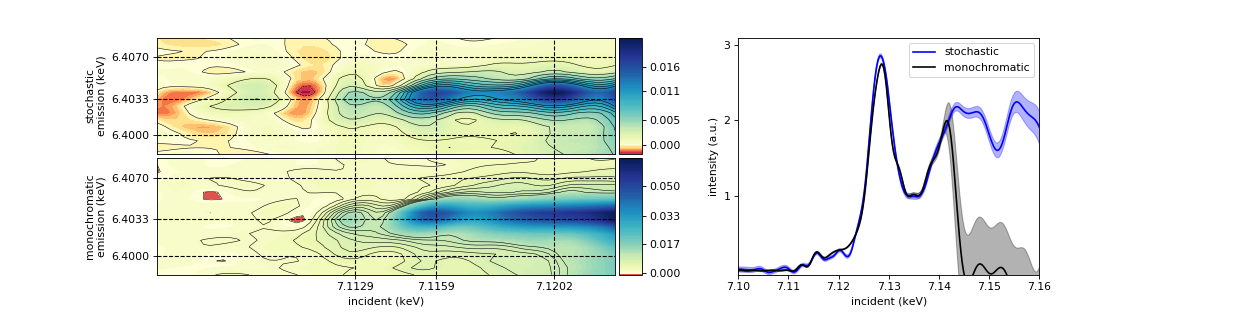

In [169]:
plot_rixs_composite(pred_raxis, pred_qaxis, mstar, sstar, mcorr, scorr, name='42k_shot_rixs_herfd_composite', save=True)

<IPython.core.display.Javascript object>


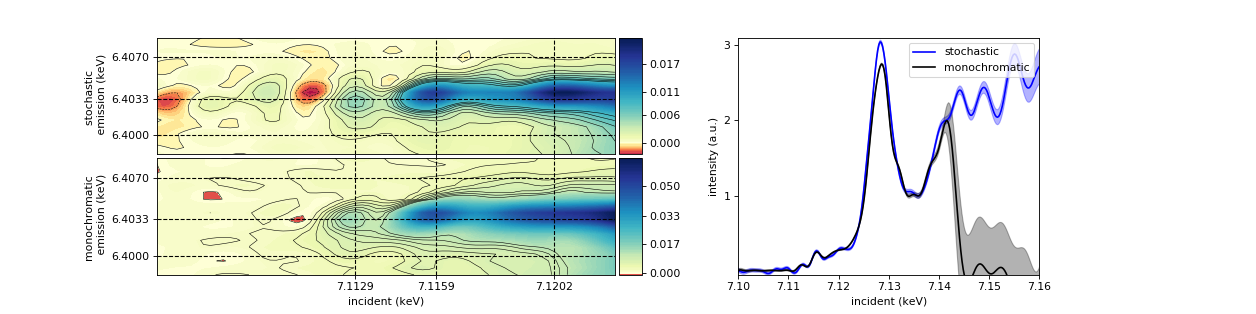

In [167]:
plot_rixs_composite(pred_raxis, pred_qaxis, mpink, spink, mcorr, scorr, name='101k_shot_rixs_herfd_composite', save=True)